In [1]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [2]:
!pip install mshr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri

In [4]:
# Follow https://fenics-handson.readthedocs.io/en/latest/navierstokes/doc.html#stokes-flow-around-cylinder
def build_space(N_circle, N_bulk, u_in):
    """Prepare data for DGF benchmark. Return function
    space, list of boundary conditions and surface measure
    on the cylinder."""

    # Define domain
    center = Point(0.2, 0.2)
    radius = 0.05
    L = 2.2
    W = 0.41
    geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
             - mshr.Circle(center, radius, N_circle)

    # Build mesh
    mesh = mshr.generate_mesh(geometry, N_bulk)

    # Construct facet markers
    bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    for f in facets(mesh):
        mp = f.midpoint()
        if near(mp[0], 0.0):  # inflow
            bndry[f] = 1
        elif near(mp[0], L):  # outflow
            bndry[f] = 2
        elif near(mp[1], 0.0) or near(mp[1], W):  # walls
            bndry[f] = 3
        elif mp.distance(center) <= radius:  # cylinder
            bndry[f] = 5

    # Build function spaces (Taylor-Hood)
    P2 = VectorElement("P", mesh.ufl_cell(), 2)
    P1 = FiniteElement("P", mesh.ufl_cell(), 1)
    TH = MixedElement([P2, P1])
    W = FunctionSpace(mesh, TH)

    # Prepare Dirichlet boundary conditions
    bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
    bc_cylinder = DirichletBC(W.sub(0), (0, 0), bndry, 5)
    bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
    bcs = [bc_cylinder, bc_walls, bc_in]

    # Prepare surface measure on cylinder
    ds_circle = Measure("ds", subdomain_data=bndry, subdomain_id=5)

    return mesh, W, bcs, ds_circle


def solve_stokes(W, nu, bcs):
    """Solve steady Stokes and return the solution"""

    # Define variational forms
    u, p = TrialFunctions(W)
    v, q = TestFunctions(W)
    a = nu*inner(grad(u), grad(v))*dx - p*div(v)*dx - q*div(u)*dx
    L = inner(Constant((0, 0)), v)*dx

    # Solve the problem
    w = Function(W)
    solve(a == L, w, bcs)

    return w

In [5]:
u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),
                    degree=2, U=0.3)
nu = Constant(0.001)

# Discretization parameters
N_circle = 128
N_bulk = 256

# Prepare function space, BCs and measure on circle
mesh, W, bcs, ds_circle = build_space(N_circle, N_bulk, u_in)

# Solve Stokes
w = solve_stokes(W, nu, bcs)

In [6]:
center = Point(0.2, 0.2)
radius = 0.05
L = 2.2
W = 0.41

bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
for f in facets(mesh):
    mp = f.midpoint()
    if near(mp[0], 0.0):  # inflow
        bndry[f] = 1
    elif near(mp[0], L):  # outflow
        bndry[f] = 2
    elif near(mp[1], 0.0) or near(mp[1], W):  # walls
        bndry[f] = 3
    elif mp.distance(center) <= radius:  # cylinder
        bndry[f] = 5


inflow_coords = []
outflow_coords = []
wall_coords = []
cylinder_coords = []

for f in facets(mesh):
    if bndry[f] == 1:  # inflow
        for vertex in vertices(f):
            inflow_coords.append(vertex.point().array())
    elif bndry[f] == 2:  # outflow
        for vertex in vertices(f):
            outflow_coords.append(vertex.point().array())
    elif bndry[f] == 3:  # walls
        for vertex in vertices(f):
            wall_coords.append(vertex.point().array())
    elif bndry[f] == 5:  # cylinder
        for vertex in vertices(f):
            cylinder_coords.append(vertex.point().array())

inflow_coords = np.array(inflow_coords)[:,:2]
outflow_coords = np.array(outflow_coords)[:,:2]
wall_coords = np.array(wall_coords)[:,:2]
cylinder_coords = np.array(cylinder_coords)[:,:2]

coords = mesh.coordinates()
x = coords[:, 0]
y = coords[:, 1]

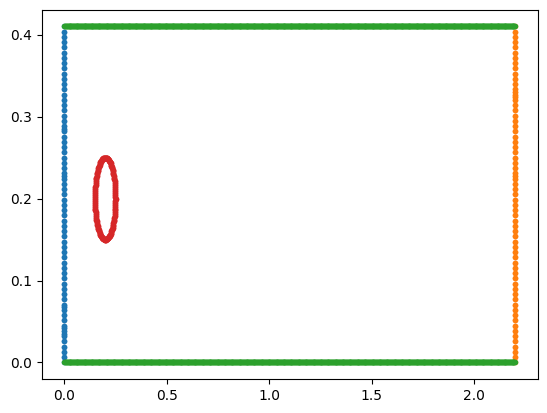

In [7]:
# Plot boundary points
plt.plot(inflow_coords[:,0], inflow_coords[:,1], '.')
plt.plot(outflow_coords[:,0], outflow_coords[:,1], '.')
plt.plot(wall_coords[:,0], wall_coords[:,1], '.')
plt.plot(cylinder_coords[:,0], cylinder_coords[:,1], '.')

In [8]:
# Visualization
U, p = w.split()
u, v = U.split()

u_values = np.array([u(x, y) for x, y in coords])
v_values = np.array([v(x, y) for x, y in coords])
p_values = np.array([p(x, y) for x, y in coords])

triang = tri.Triangulation(x, y)

x_tri = x[triang.triangles].mean(axis=1)
y_tri = y[triang.triangles].mean(axis=1)
dist_from_center = np.sqrt((x_tri - center[0])**2 + (y_tri - center[1])**2)
triang.set_mask(dist_from_center < radius)

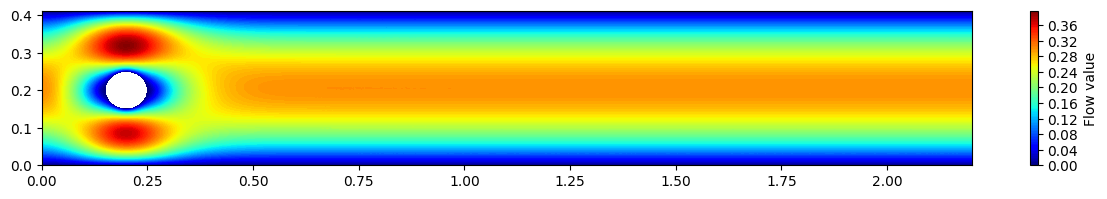

In [9]:
fig = plt.figure(figsize=(15,2))
plt.tricontourf(triang, u_values, cmap='jet', levels=100)
plt.colorbar(label='Flow value')

In [10]:
data_dict = {'u':u_values, 
             'v':v_values, 
             'p':p_values, 
             'coords':coords, 
             'inflow_coords': inflow_coords,
             'outflow_coords': outflow_coords,
             'wall_coords': wall_coords,
             'cylinder_coords': cylinder_coords,
             'nu':0.001}
np.save('stokes.npy', data_dict)